In [1]:
# Import necessary libraries and modules for building a Keras model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import os
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define the paths to the directories containing images and masks
image_path = '/kaggle/input/dataset/editData/image'  
mask_path = '/kaggle/input/dataset/editData/mask'    


In [3]:
# Function to process image and mask paths
def process_path(image_path, mask_path):
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Decode PNG images with 3 color channels
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert image to float32 format

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Decode PNG masks with 3 color channels
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Convert mask to single channel (binary mask)

    return img, mask  # Return the processed image and mask

# Function to resize images and masks
def preprocess(image, mask):
    image = tf.image.resize(image, (256, 256), method='nearest')  # Resize image to 256x256 using nearest neighbor
    mask = tf.image.resize(mask, (256, 256), method='nearest')    # Resize mask to 256x256 using nearest neighbor
    return image, mask  # Return resized image and mask

# Get sorted lists of image and mask file paths
image_list = sorted([os.path.join(image_path, i) for i in os.listdir(image_path)])  # List of image paths
mask_list = sorted([os.path.join(mask_path, i) for i in os.listdir(mask_path)])      # List of mask paths

# Create TensorFlow datasets from the lists of image and mask paths
image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)  # Dataset of image paths
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)    # Dataset of mask paths

# Zip the image and mask datasets to pair each image with its corresponding mask
dataset = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

# Apply the processing and preprocessing functions to the dataset
processed_image_ds = dataset.map(process_path).map(preprocess)

# Function to count the number of elements in a dataset
def count_elements(dataset):
    return sum(1 for _ in dataset)  # Count each element in the dataset

# Function to split dataset into train, validation, and test sets
BUFFER_SIZE = 500
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)  
    total_size = count_elements(dataset)  
    train_size = int(total_size * train_size)  
    val_size = int(total_size * val_size)     
    test_size = int(total_size * test_size)    
    train_ds = dataset.take(train_size)        
    val_ds = dataset.skip(train_size).take(val_size)  
    test_ds = dataset.skip(train_size + val_size)  
    return train_ds, val_ds, test_ds 

# Split the processed dataset into training, validation, and test sets
train_ds, val_ds, test_ds = split_dataset(processed_image_ds)

# Function to prepare datasets for training
def prepare_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)  # Batch the dataset
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch data for performance
    return dataset

# Prepare training, validation, and test datasets
BATCH_SIZE = 16
train_dataset = prepare_dataset(train_ds, BATCH_SIZE)
val_dataset = prepare_dataset(val_ds, BATCH_SIZE)
test_dataset = prepare_dataset(test_ds, BATCH_SIZE)

# Function to apply augmentations to images and masks
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        # Randomly flip the image and mask horizontally
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        # Randomly flip the image and mask vertically
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        # Randomly rotate the image and mask by 90 degrees
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)

    return image, mask  

# Apply augmentation to the training dataset
train_dataset = train_dataset.map(lambda image, mask: augment(image, mask))

# Function to print the shapes of images and masks in the dataset
def print_shapes(dataset, num_batches=1):
    for images, masks in dataset.take(num_batches):  
        print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")  
        break  

# Print shapes of datasets
print("Train Dataset:")
print_shapes(train_dataset)

print("\nValidation Dataset:")
print_shapes(val_dataset)

print("\nTest Dataset:")
print_shapes(test_dataset)

# Learning rate scheduler to reduce the learning rate when a plateau in validation loss is detected
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by this factor
    patience=3,          # Number of epochs with no improvement to wait before reducing
    verbose=1,           # Print messages when learning rate is reduced
    min_lr=1e-6          # Lower bound for learning rate
)


Train Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Validation Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Test Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)


Sample 1:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


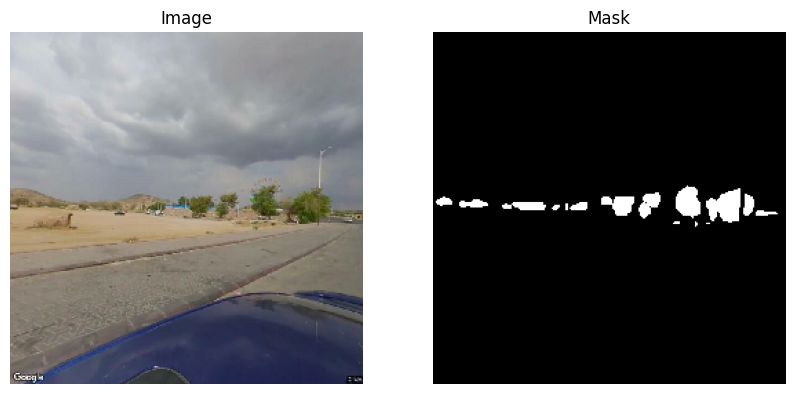

Sample 2:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


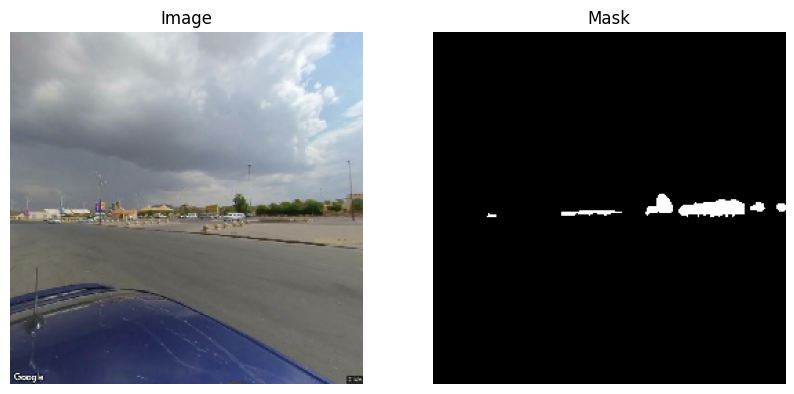

Sample 3:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


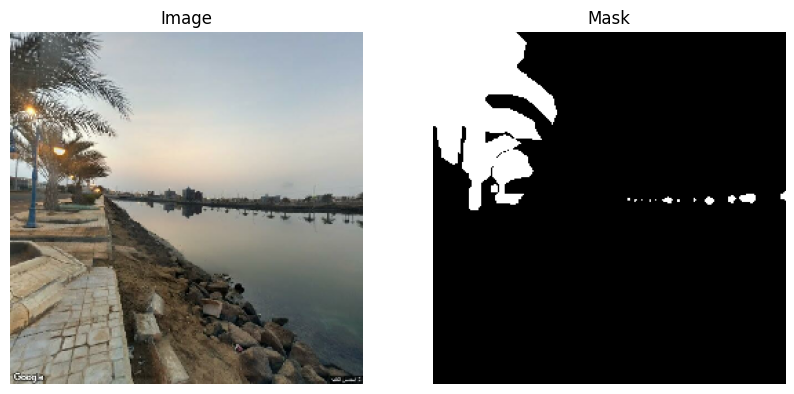

Sample 4:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


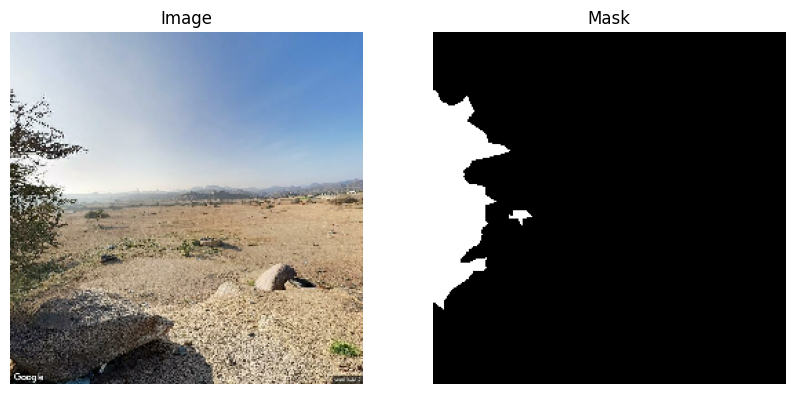

Sample 5:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


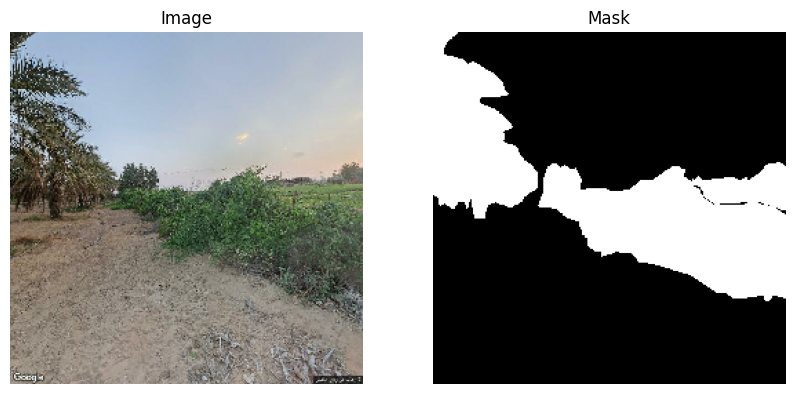

In [4]:
# to visualize sample from the dataset
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

def visual_dataset(dataset, num_samples=5):
    sample_images = []
    sample_masks = []
    for image, mask in dataset.take(num_samples):
        sample_images.append(image.numpy())
        sample_masks.append(mask.numpy())
    
    # Visualize the samples
    for i in range(num_samples):
        print(f"Sample {i + 1}:")
        print("Image shape:", sample_images[i].shape)
        print("Mask unique values:", np.unique(sample_masks[i]))
        visualize_sample(sample_images[i], sample_masks[i])

# Call the inspect function on your dataset
visual_dataset(train_ds)


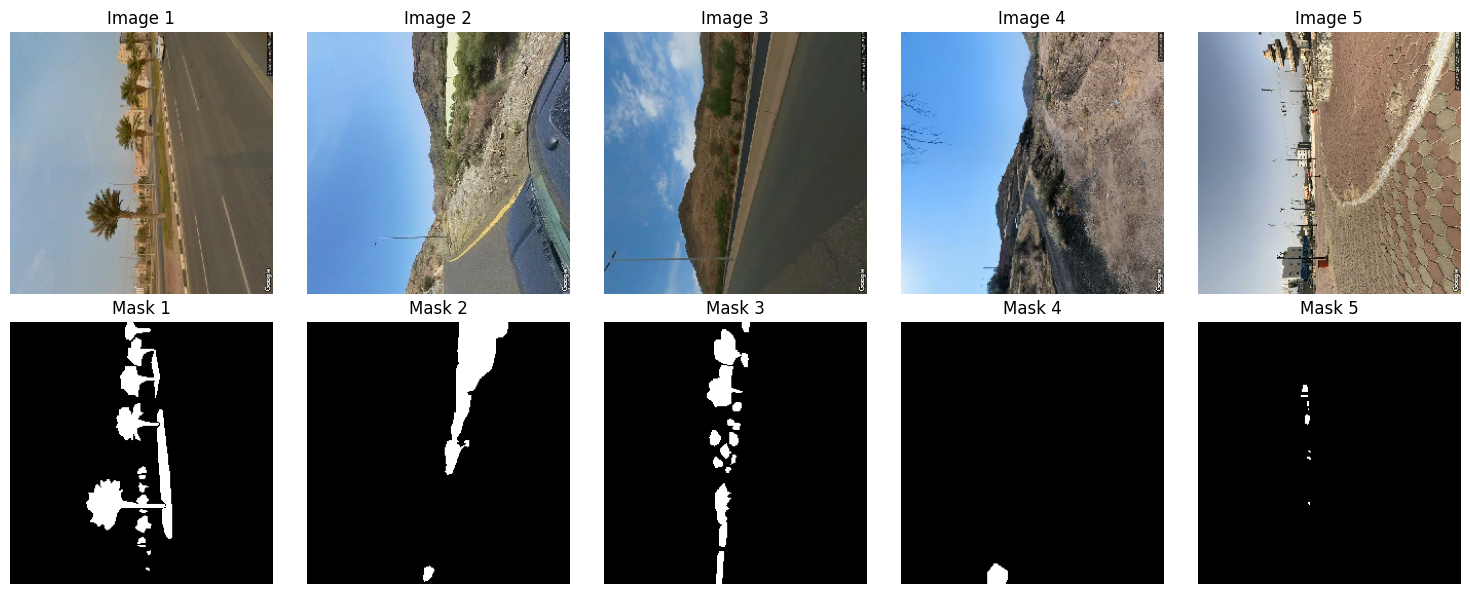

In [5]:
# visualize sample from training dataset
def visualize_subset(train_dataset, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    for i, (img_batch, mask_batch) in enumerate(train_dataset.take(1)):  # one batch
        for j in range(num_samples):
            
            img = img_batch[j].numpy()
            mask = mask_batch[j].numpy()

            plt.subplot(2, num_samples, j + 1)
            plt.title(f"Image {j + 1}")
            plt.imshow(img)  # Display the image
            plt.axis('off')
            
            plt.subplot(2, num_samples, num_samples + j + 1)
            plt.title(f"Mask {j + 1}")
            plt.imshow(mask.squeeze(), cmap='gray')  # Display the mask
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_subset(train_dataset, num_samples=5)

In [6]:
# For handling class imbalance
from sklearn.utils import class_weight

# Function to extract labels from the dataset
def extract_labels(dataset):
    all_masks = []  
    for images, masks in dataset:  
        all_masks.append(masks.numpy())  
    return np.concatenate(all_masks, axis=0).flatten()  

# Extract labels (masks) from the training dataset
y_train = extract_labels(train_dataset)

# Get unique class labels from the extracted labels
class_labels = np.unique(y_train)

# Compute class weights to handle class imbalance
weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Use balanced class weights
    classes=class_labels,      # List of unique class labels
    y=y_train                  # Array of class labels (masks)
)

# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = {i: weights[i] for i in range(len(weights))}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.5274925717540836, 1: 9.593365372879921}


In [7]:

# Function to compute the Dice coefficient
def dice_coef(y_true, y_pred, smooth=1):

    # Flatten the true and predicted masks and ensure they are float32
    y_true_f = K.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.cast(K.flatten(y_pred), tf.float32)
    
    # Calculate intersection
    intersection = K.sum(y_true_f * y_pred_f)
    
    # Calculate and return the Dice coefficient
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Function to compute the Dice loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Function to compute the Intersection over Union (IoU) metric
def iou_metric(y_true, y_pred, smooth=1e-6):

    # Reshape true and predicted labels and cast to float32
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)  
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Calculate and return IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Function to compute the Dice loss with a smoothing factor
def dice_loss(y_true, y_pred, smooth=1e-6):

    # Reshape true and predicted labels and cast to float32
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and Dice coefficient
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    
    # Return the Dice loss
    return 1 - dice_coeff  


In [8]:

# Function to create a convolutional block
def conv_block(inputs, n_filters=32, dropout_prob=0):
    """
    Create a convolutional block with two convolutional layers .
    x: Output tensor after applying convolutions and batch normalization.
    """
    # First convolution layer
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal',
               kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)  # Batch normalization
    x = tf.keras.activations.relu(x)  # ReLU activation

    # Second convolution layer
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal',
               kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization
    x = tf.keras.activations.relu(x)  # ReLU activation

    # Apply dropout if specified
    if dropout_prob > 0:
        x = Dropout(dropout_prob)(x)

    return x  # Return the output tensor

# Function to create an upsampling block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Create an upsampling block for the U-Net architecture.
    x: Output tensor after upsampling and convolutions.
    """
    up = Conv2DTranspose(n_filters, 2, strides=2, padding='same')(expansive_input)  # Upsampling
    merged = concatenate([up, contractive_input], axis=3)  # Concatenate with contractive path

    x = conv_block(merged, n_filters)  # Apply convolutional block
    return x  # Return the output tensor

# Function to create the U-Net model
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    """
    Create the U-Net model architecture.
    model: Compiled U-Net model.
    """
    inputs = Input(input_size)  # Input layer

    # Contracting Path
    c1 = conv_block(inputs, n_filters)  # First convolutional block
    p1 = MaxPooling2D()(c1)  # Max pooling

    c2 = conv_block(p1, n_filters * 2)  # Second convolutional block
    p2 = MaxPooling2D()(c2)  # Max pooling

    c3 = conv_block(p2, n_filters * 4)  # Third convolutional block
    p3 = MaxPooling2D()(c3)  # Max pooling

    c4 = conv_block(p3, n_filters * 8, dropout_prob=0.2)  # Fourth convolutional block
    p4 = MaxPooling2D()(c4)  # Max pooling

    c5 = conv_block(p4, n_filters * 16, dropout_prob=0.2)  # Bottleneck convolutional block

    # Expanding Path
    u1 = upsampling_block(c5, c4, n_filters * 8)  # First upsampling block
    u2 = upsampling_block(u1, c3, n_filters * 4)  # Second upsampling block
    u3 = upsampling_block(u2, c2, n_filters * 2)  # Third upsampling block
    u4 = upsampling_block(u3, c1, n_filters)  # Fourth upsampling block

    outputs = Conv2D(1, 1, activation='sigmoid')(u4)  # Output layer with sigmoid activation

    model = Model(inputs=inputs, outputs=outputs)  # Create the model
    return model  # Return the model

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Create the U-Net model
unet = unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1)

# Compile the model with an optimizer, loss function, and metrics
unet.compile(optimizer=AdamW(learning_rate=0.0001),
              loss=dice_loss,  
              metrics=['accuracy', 'Precision', 'Recall', dice_coef, iou_metric]) 


In [9]:
history = unet.fit(
    train_dataset,class_weight=class_weight_dict,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[
        lr_scheduler, 
        early_stopping ])

Epoch 1/50


I0000 00:00:1729607210.059692      93 service.cc:145] XLA service 0x7f562c0c2400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729607210.059764      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/388 ━━━━━━━━━━━━━━━━━━━━ 4:05:24 38s/step - Precision: 0.0588 - Recall: 0.4513 - accuracy: 0.4589 - dice_coef: 0.1145 - iou_metric: 0.0607 - loss: 6.9169

I0000 00:00:1729607232.933373      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 129s 234ms/step - Precision: 0.1954 - Recall: 0.8913 - accuracy: 0.7821 - dice_coef: 0.2070 - iou_metric: 0.1204 - loss: 4.7888 - val_Precision: 0.7525 - val_Recall: 0.6712 - val_accuracy: 0.9698 - val_dice_coef: 0.3260 - val_iou_metric: 0.2013 - val_loss: 1.9692 - learning_rate: 1.0000e-04
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 87s 219ms/step - Precision: 0.5195 - Recall: 0.8520 - accuracy: 0.9497 - dice_coef: 0.3818 - iou_metric: 0.2476 - loss: 1.6461 - val_Precision: 0.5649 - val_Recall: 0.8868 - val_accuracy: 0.9573 - val_dice_coef: 0.4641 - val_iou_metric: 0.3138 - val_loss: 1.1838 - learning_rate: 1.0000e-04
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 87s 218ms/step - Precision: 0.6225 - Recall: 0.8230 - accuracy: 0.9633 - dice_coef: 0.4876 - iou_metric: 0.3386 - loss: 1.0699 - val_Precision: 0.6988 - val_Recall: 0.8966 - val_accuracy: 0.9741 - val_dice_coef: 0.5694 - val_iou_metric: 0.4122 - val_loss: 0.9092 - learning_rate: 1.0000e-04
Epoch 4/50
388/38

In [10]:
# Evaluate the model on the train dataset
train_loss, train_acc, train_precision_m, train_recall_m,train_dice_coef, train_iou_metric = unet.evaluate(train_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'train Loss:':<20}{train_loss:>10.4f}")
print(f"{'train Accuracy:':<20}{train_acc:>10.4f}")
print(f"{'Precision:':<20}{train_precision_m:>10.4f}")
print(f"{'Recall:':<20}{train_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{train_iou_metric:>10.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - Precision: 0.8575 - Recall: 0.8915 - accuracy: 0.9859 - dice_coef: 0.8597 - iou_metric: 0.7596 - loss: 0.2944
Metric                   Value
------------------------------
train Loss:             0.2941
train Accuracy:         0.9873
Precision:              0.8709
Recall:                 0.8926
Dice Coefficient:       0.8600
IoU Metric:             0.7613


In [11]:
# Evaluate the model on the val dataset
val_loss, val_acc, val_precision_m, val_recall_m,val_dice_coef, val_iou_metric = unet.evaluate(val_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'val Loss:':<20}{val_loss:>10.4f}")
print(f"{'val Accuracy:':<20}{val_acc:>10.4f}")
print(f"{'Precision:':<20}{val_precision_m:>10.4f}")
print(f"{'Recall:':<20}{val_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{val_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{val_iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - Precision: 0.8816 - Recall: 0.8833 - accuracy: 0.9883 - dice_coef: 0.8751 - iou_metric: 0.7805 - loss: 0.2790
Metric                   Value
------------------------------
val Loss:               0.2882
val Accuracy:           0.9879
Precision:              0.8695
Recall:                 0.8854
Dice Coefficient:       0.8656
IoU Metric:             0.7680


In [12]:
# Evaluate the model on the test dataset
test_loss, test_acc, test_precision_m, test_recall_m,test_dice_coef, test_iou_metric = unet.evaluate(test_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'train Loss:':<20}{test_loss:>10.4f}")
print(f"{'train Accuracy:':<20}{test_acc:>10.4f}")
print(f"{'Precision:':<20}{test_precision_m:>10.4f}")
print(f"{'Recall:':<20}{test_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{test_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{test_iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - Precision: 0.8702 - Recall: 0.8659 - accuracy: 0.9811 - dice_coef: 0.8670 - iou_metric: 0.7693 - loss: 0.2871
Metric                   Value
------------------------------
train Loss:             0.2944
train Accuracy:         0.9830
Precision:              0.8571
Recall:                 0.8709
Dice Coefficient:       0.8598
IoU Metric:             0.7593


In [13]:
# Evaluate on training dataset
train_loss, train_acc, train_precision, train_recall,train_dice_coef, train_iou = unet.evaluate(train_dataset)

# Evaluate on validation dataset
val_loss, val_acc, val_precision, val_recall,val_dice_coef, val_iou = unet.evaluate(val_dataset)

# Evaluate on test dataset
test_loss, test_acc,test_precision, test_recall,test_dice_coef, test_iou = unet.evaluate(test_dataset)

print(f"{'Metric':<20}{'Train':>12}{'Validation':>12}{'Test':>12}")
print(f"{'-'*50}")
print(f"{'Loss:':<20}{train_loss:>12.4f}{val_loss:>12.4f}{test_loss:>12.4f}")
print(f"{'Accuracy:':<20}{train_acc:>12.4f}{val_acc:>12.4f}{test_acc:>12.4f}")
print(f"{'Precision:':<20}{train_precision:>12.4f}{val_precision:>12.4f}{test_precision:>12.4f}")
print(f"{'Recall:':<20}{train_recall:>12.4f}{val_recall:>12.4f}{test_recall:>12.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>12.4f}{val_dice_coef:>12.4f}{test_dice_coef:>12.4f}")
print(f"{'IoU Metric:':<20}{train_iou:>12.4f}{val_iou:>12.4f}{test_iou:>12.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - Precision: 0.8554 - Recall: 0.8854 - accuracy: 0.9859 - dice_coef: 0.8536 - iou_metric: 0.7511 - loss: 0.3005
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - Precision: 0.8684 - Recall: 0.8812 - accuracy: 0.9887 - dice_coef: 0.8620 - iou_metric: 0.7642 - loss: 0.2921
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - Precision: 0.8794 - Recall: 0.8841 - accuracy: 0.9848 - dice_coef: 0.8807 - iou_metric: 0.7901 - loss: 0.2734
Metric                     Train  Validation        Test
--------------------------------------------------
Loss:                     0.2936      0.3081      0.2916
Accuracy:                 0.9873      0.9862      0.9828
Precision:                0.8717      0.8440      0.8608
Recall:                   0.8914      0.8775      0.8731
Dice Coefficient:         0.8604      0.8466      0.8626
IoU Metric:               0.7618      0.7441      0.7645


In [14]:
# Calculate F1 Score
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Print metrics including F1 Score
print(f"{'Metric':<20}{'Train':>12}{'Validation':>12}{'Test':>12}")
print(f"{'-'*50}")
print(f"{'Loss:':<20}{train_loss:>12.4f}{val_loss:>12.4f}{test_loss:>12.4f}")
print(f"{'Accuracy:':<20}{train_acc:>12.4f}{val_acc:>12.4f}{test_acc:>12.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>12.4f}{val_dice_coef:>12.4f}{test_dice_coef:>12.4f}")
print(f"{'Precision:':<20}{train_precision:>12.4f}{val_precision:>12.4f}{test_precision:>12.4f}")
print(f"{'Recall:':<20}{train_recall:>12.4f}{val_recall:>12.4f}{test_recall:>12.4f}")
print(f"{'IoU Metric:':<20}{train_iou:>12.4f}{val_iou:>12.4f}{test_iou:>12.4f}")
print(f"{'F1 Score:':<20}{train_f1:>12.4f}{val_f1:>12.4f}{test_f1:>12.4f}")

Metric                     Train  Validation        Test
--------------------------------------------------
Loss:                     0.2936      0.3081      0.2916
Accuracy:                 0.9873      0.9862      0.9828
Dice Coefficient:         0.8604      0.8466      0.8626
Precision:                0.8717      0.8440      0.8608
Recall:                   0.8914      0.8775      0.8731
IoU Metric:               0.7618      0.7441      0.7645
F1 Score:                 0.8814      0.8604      0.8669


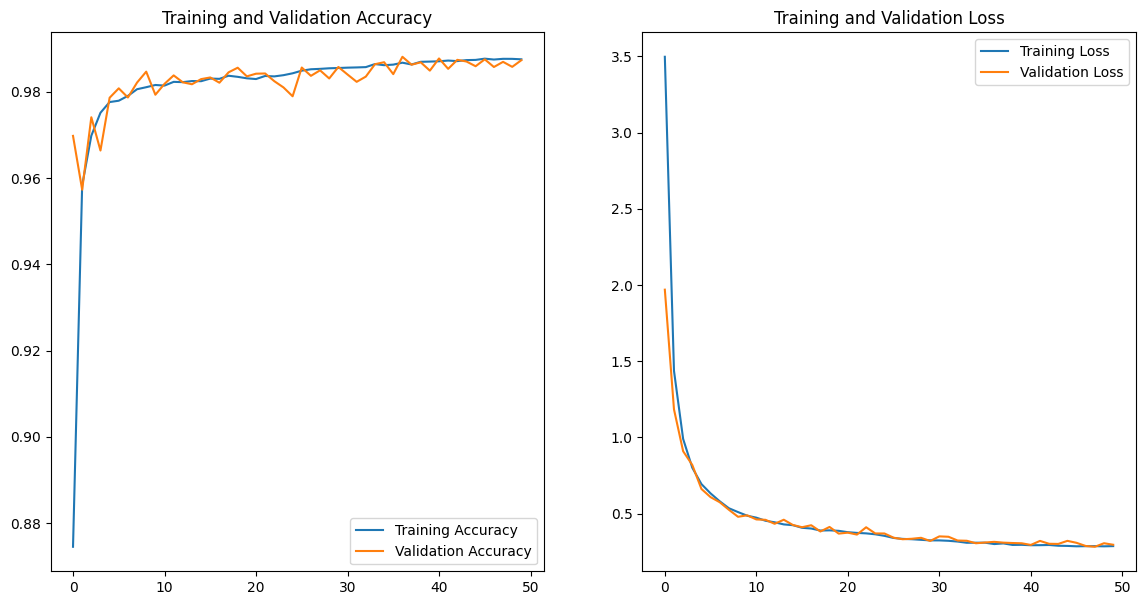

In [15]:

# Accuracy plot
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

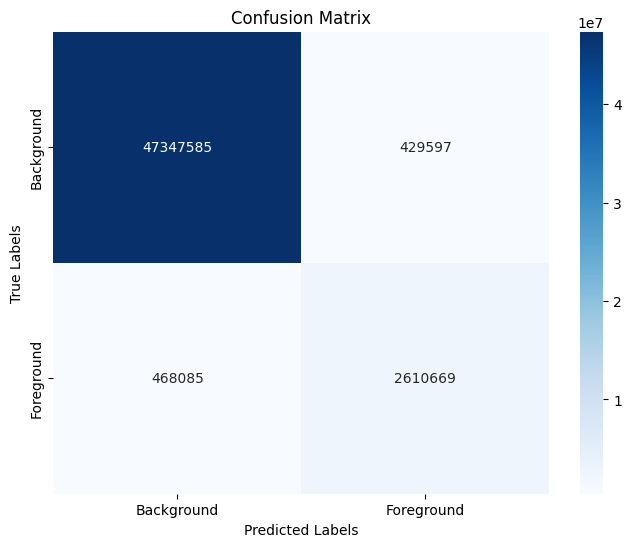

In [16]:

def evaluate_model_on_test(test_dataset, model):
    all_true_masks = []
    all_pred_masks = []

    # Iterate through the test dataset
    for images, true_masks in test_dataset:
        # Predict masks
        preds = model.predict(images)
        preds = tf.math.round(preds)  # Round predictions to binary (0 or 1)

        # Convert tensors to numpy arrays and flatten them
        true_masks_np = tf.squeeze(true_masks).numpy().astype(np.uint8).flatten()
        preds_np = tf.squeeze(preds).numpy().astype(np.uint8).flatten()

        # Append to lists
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(preds_np)

    # Flatten the lists
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)

    # Generate classification report
    report = classification_report(all_true_masks, all_pred_masks, target_names=['Background', 'Foreground'])
    cm = confusion_matrix(all_true_masks, all_pred_masks)

    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

evaluate_model_on_test(test_dataset, unet)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


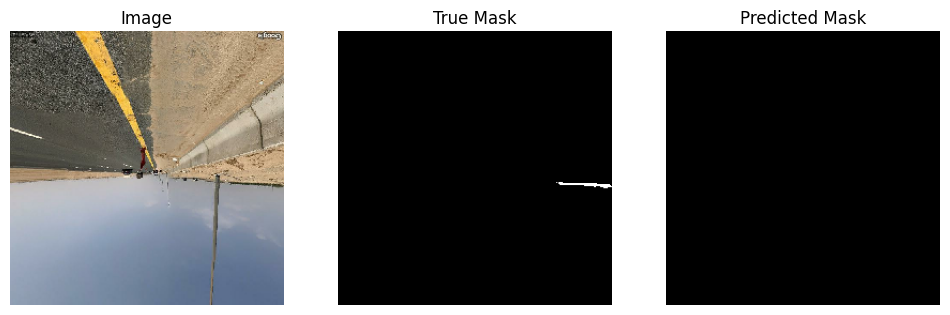

In [17]:

def create_mask(pred_mask):

    pred_mask = np.squeeze(pred_mask)  
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  
    return pred_mask
import matplotlib.pyplot as plt

def display(images):
    plt.figure(figsize=(12, 6))
    
    titles = ['Image', 'True Mask', 'Predicted Mask']
    
    for i, img in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        img_np = img.numpy() if hasattr(img, 'numpy') else img
        plt.imshow(np.squeeze(img_np), cmap='gray')  
        plt.axis('off')
    
    plt.show()
def show_predictions(dataset, num=1):

    for image, mask in dataset.take(num):
        image_np = image.numpy()
        mask_np = mask.numpy()
        
        pred_mask = unet.predict(image_np)
        pred_mask_np = create_mask(pred_mask[0])
        
        display([image_np[0], mask_np[0], pred_mask_np])
show_predictions(train_dataset, num=1)



In [18]:

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.convert_image_dtype(img, tf.float32)  
    img = tf.image.resize(img, (256, 256)) 
    img = tf.expand_dims(img, axis=0) 
    return img

def predict_image(model, image_path):
    img = load_and_preprocess_image(image_path)

    predictions = model.predict(img)

    pred_binary = (predictions > 0.5).astype(np.uint8) 
    
    return pred_binary

def display_results(original_img_path, pred_mask):
    original_img = tf.io.read_file(original_img_path)
    original_img = tf.image.decode_png(original_img, channels=3)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img.numpy())
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask[0, :, :, 0], cmap='gray')  
    plt.axis("off")

    plt.show()

image_path = '/kaggle/input/tttttttt/image_21.498515619750663_39.23344846806022_90_2019-04.jpg' 
image_path1 = '/kaggle/input/tttttttt/image_21.498489380489325_39.24375572011248_90_2019-04.jpg'  
image_path2 = '/kaggle/input/tttttttt/image_21.498489380489325_39.24375572011248_270_2019-04.jpg'  
image_path3 = '/kaggle/input/tttttttt/download (1).jpg'  

predicted_mask = predict_image(unet, image_path)
predicted_mask1 = predict_image(unet, image_path1)
predicted_mask2 = predict_image(unet, image_path2)
predicted_mask3 = predict_image(unet, image_path3)

display_results(image_path, predicted_mask)
display_results(image_path1, predicted_mask1)
display_results(image_path2, predicted_mask2)
display_results(image_path3, predicted_mask3)

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /kaggle/input/tttttttt/image_21.498515619750663_39.23344846806022_90_2019-04.jpg; No such file or directory [Op:ReadFile]

In [ ]:
unet.save('/kaggle/working/Funet_model.h5')
